In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import wrds

from dotenv import dotenv_values
config = dotenv_values(".env")

from mylib.load_from_wrds import query_options_stock, query_zero_curve
from mylib.rates_tools import create_yield_curve, merge_interest
from mylib.construct_tracer import construct_tracer
from mylib.BS_formulas import bs_delta, bs_IV, bs_IV_vec
from mylib.regression import regression_rolling

%load_ext autoreload
%autoreload 2

In [2]:
secid = 113993
name = "GameStop"
ticker = "GME"

# secid = 189943
# name = "AMC Theatres"
# ticker = "AMC"

startdate = '2019-01-01'
enddate = '2023-12-31'

ALLOWED_ADJ_FACTOR_CHANGE = [0.99, 1.01]    #to filter options where adjustment factor changes over lifetime

# Download data from WRDS and do some preliminary cleaning

In [3]:
%%time

db = wrds.Connection(wrds_username=config['WRDS_USER'])

df_option = query_options_stock(db, secid, startdate=startdate, enddate=enddate)
zero_curve = query_zero_curve(db, startdate=startdate, enddate=enddate)

db.close()

Loading library list...
Done
CPU times: user 6.1 s, sys: 1.14 s, total: 7.24 s
Wall time: 18.4 s


In [6]:
print(df_option.shape)
df_option.sample(3)

(1228842, 20)


,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,splitfactor,adj_fac_expiration,M0,open_total_interest
68983,113993.0,128061995.0,2019-05-03,2019-10-18,C,0.637923,0.020178,0.0,0.0,100.0,168,0.466667,5.500,0.00625,2.2425,11.907896,0.25,11.907896,0.407727,72594.0
126884,113993.0,133128864.0,2021-01-08,2021-04-16,P,1.448095,-0.013867,0.0,236.0,100.0,98,0.272222,1.125,0.02125,4.4225,11.907896,0.25,11.907896,3.931111,436825.0
113977,113993.0,130730223.0,2019-09-30,2019-10-25,C,2.088205,0.208615,0.0,0.0,100.0,25,0.069444,2.500,0.07000,1.3800,11.907896,0.25,11.907896,0.552000,128264.0


In [7]:
def filter_adj_factor_change(df, ALLOWED_ADJ_FACTOR_CHANGE=[0.99, 1.01]):
    adj_change = df['adj_fac_expiration'] / df['adj_fac0']
    bl = (ALLOWED_ADJ_FACTOR_CHANGE[0] > adj_change) | (adj_change > ALLOWED_ADJ_FACTOR_CHANGE[1])    
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) options that are removed due to a large change in adjustment factor.')
    
    return df[~bl]

In [6]:
df_option = filter_adj_factor_change(df_option, ALLOWED_ADJ_FACTOR_CHANGE)

There are 15266 (1.24%) options that are removed due to a large change in adjustment factor.


Add interest rates and underlying info to options dataframe:

In [7]:
df_option.loc[df_option['date'].isin(['2021-01-25']) & (abs(df_option['S0'] - df_option['K']) < 5), :].head(2)

,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,splitfactor,adj_fac_expiration,M0,open_total_interest
524797,113993.0,138096584.0,2021-01-25,2021-01-29,C,NaN,NaN,622.0,782.0,100.0,4,0.011111,14.25,6.6250,19.1975,11.907896,0.25,11.907896,1.347193,320534.0
524798,113993.0,138096585.0,2021-01-25,2021-01-29,C,NaN,NaN,855.0,1263.0,100.0,4,0.011111,14.50,6.5375,19.1975,11.907896,0.25,11.907896,1.323966,320534.0


In [8]:
%%time

df_rate = create_yield_curve(zero_curve, max_days=1500) 
df = merge_interest(df_option, df_rate)

CPU times: user 2.88 s, sys: 2.01 s, total: 4.9 s
Wall time: 5.3 s


In [9]:
df.loc[df['date'].isin(['2021-01-25']) & (abs(df['S0'] - df['K']) < 5), :].head(2)

,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,...,K,V0,S0,adj_fac0,splitfactor,adj_fac_expiration,M0,open_total_interest,short_rate,r
254774,113993.0,138096584.0,2021-01-25,2021-01-29,C,NaN,NaN,622.0,782.0,100.0,...,14.25,6.6250,19.1975,11.907896,0.25,11.907896,1.347193,320534.0,0.000982,0.000982
254775,113993.0,138096585.0,2021-01-25,2021-01-29,C,NaN,NaN,855.0,1263.0,100.0,...,14.50,6.5375,19.1975,11.907896,0.25,11.907896,1.323966,320534.0,0.000982,0.000982


In [26]:
%%time
# add BS Implied Volatility
from concurrent.futures import ThreadPoolExecutor
from mylib.BS_formulas import bs_delta, bs_IV, bs_IV_vec

df.loc[df['IV0'].isna(), 'bs_IV'] = bs_IV_vec(df.loc[df['IV0'].isna(), 'V0'], 
                                              df.loc[df['IV0'].isna(), 'S0'], 
                                              df.loc[df['IV0'].isna(), 'K'], 
                                              df.loc[df['IV0'].isna(), 'tau'], 
                                              df.loc[df['IV0'].isna(), 'r'], 
                                              df.loc[df['IV0'].isna(), 'cp_flag'])

df['IV0_is_inputed'] = df['IV0'].isna()
df.loc[df['IV0'].isna(), 'IV0'] = df.loc[df['IV0'].isna(), 'bs_IV']

CPU times: user 10min 7s, sys: 4min 41s, total: 14min 48s
Wall time: 10min 29s


# try multi-variate minization (can be deleted later)

In [13]:
pd.set_option('display.max_columns', None)
df.loc[df['IV0'].isna() & (df['date'] == '2021-01-25') & (df['tau_days'] < 100) & (df['tau_days'] > 20) \
       & (abs(df['S0'] - df['K']) < 30) & (df['K'] == 4.750), :].head(20) # try optionid == 137524262.0 as an example

,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,splitfactor,adj_fac_expiration,M0,open_total_interest,short_rate,r
255389,113993.0,137524262.0,2021-01-25,2021-02-19,C,NaN,NaN,1268.0,749.0,100.0,25,0.069444,4.75,14.43750,19.1975,11.907896,0.25,11.907896,4.041579,320534.0,0.000982,0.001225
255474,113993.0,137524279.0,2021-01-25,2021-02-19,P,NaN,NaN,1186.0,1312.0,100.0,25,0.069444,4.75,0.30500,19.1975,11.907896,0.25,11.907896,4.041579,534756.0,0.000982,0.001225
255672,113993.0,137869038.0,2021-01-25,2021-02-26,P,NaN,NaN,137.0,99.0,100.0,32,0.088889,4.75,0.42125,19.1975,11.907896,0.25,11.907896,4.041579,534756.0,0.000982,0.001340
256009,113993.0,137959416.0,2021-01-25,2021-03-19,P,NaN,NaN,654.0,314.0,100.0,53,0.147222,4.75,0.60500,19.1975,11.907896,0.25,11.907896,4.041579,534756.0,0.000982,0.001627


In [26]:
df.loc[(df['date'] == '2021-01-25') & (df['tau_days'] == 25) & (df['cp_flag'] == 'P') \
       & (df['K'] == 9), :].head(20) # try optionid == 137524262.0 as an example

,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,splitfactor,adj_fac_expiration,M0,open_total_interest,short_rate,r
255491,113993.0,137759499.0,2021-01-25,2021-02-19,P,NaN,NaN,721.0,349.0,100.0,25,0.069444,9.0,1.4125,19.1975,11.907896,0.25,11.907896,2.133056,534756.0,0.000982,0.001225


In [28]:
df.loc[(df['date'] == '2021-01-25') & (df['tau_days'] == 25) & (df['cp_flag'] == 'P') \
       & (df['K'] == 9), :].head(20) # try optionid == 137524262.0 as an example

,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,splitfactor,adj_fac_expiration,M0,open_total_interest,short_rate,r
255491,113993.0,137759499.0,2021-01-25,2021-02-19,P,NaN,NaN,721.0,349.0,100.0,25,0.069444,9.0,1.4125,19.1975,11.907896,0.25,11.907896,2.133056,534756.0,0.000982,0.001225


In [22]:
df.loc[(df['optionid'] == 137524279.0) & (df['date'] > '2021-01-14') & (df['date'] < '2021-01-31'), :]

,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,splitfactor,adj_fac_expiration,M0,open_total_interest,short_rate,r
248422,113993.0,137524279.0,2021-01-15,2021-02-19,P,1.913070,-0.088289,205.0,1755.0,100.0,35,0.097222,4.75,0.28000,8.8750,11.907896,0.25,11.907896,1.868421,621174.0,0.001020,0.001357
249772,113993.0,137524279.0,2021-01-19,2021-02-19,P,2.077485,-0.066077,1590.0,1844.0,100.0,31,0.086111,4.75,0.22375,9.8400,11.907896,0.25,11.907896,2.071579,287204.0,0.001000,0.001315
251122,113993.0,137524279.0,2021-01-20,2021-02-19,P,1.986297,-0.060205,302.0,1367.0,100.0,30,0.083333,4.75,0.18375,9.7800,11.907896,0.25,11.907896,2.058947,370658.0,0.001020,0.001301
252472,113993.0,137524279.0,2021-01-21,2021-02-19,P,1.953755,-0.039194,535.0,1395.0,100.0,29,0.080556,4.75,0.11625,10.7575,11.907896,0.25,11.907896,2.264737,404633.0,0.000983,0.001291
253895,113993.0,137524279.0,2021-01-22,2021-02-19,P,2.899435,-0.026570,608.0,1322.0,100.0,28,0.077778,4.75,0.18125,16.2525,11.907896,0.25,11.907896,3.421579,450840.0,0.000995,0.001242
255474,113993.0,137524279.0,2021-01-25,2021-02-19,P,NaN,NaN,1186.0,1312.0,100.0,25,0.069444,4.75,0.30500,19.1975,11.907896,0.25,11.907896,4.041579,534756.0,0.000982,0.001225
257452,113993.0,137524279.0,2021-01-26,2021-02-19,P,NaN,NaN,1024.0,1648.0,100.0,24,0.066667,4.75,0.24625,36.9950,11.907896,0.25,11.907896,7.788421,858355.0,0.000929,0.001166
259928,113993.0,137524279.0,2021-01-27,2021-02-19,P,NaN,NaN,898.0,1941.0,100.0,23,0.063889,4.75,0.44375,86.8775,11.907896,0.25,11.907896,18.290000,1129235.0,0.001011,0.001179
263107,113993.0,137524279.0,2021-01-28,2021-02-19,P,NaN,NaN,256.0,1901.0,100.0,22,0.061111,4.75,0.38750,48.4000,11.907896,0.25,11.907896,10.189474,1584680.0,0.000930,0.001141
266761,113993.0,137524279.0,2021-01-29,2021-02-19,P,NaN,NaN,312.0,1866.0,100.0,21,0.058333,4.75,0.48000,81.2500,11.907896,0.25,11.907896,17.105263,1709916.0,0.000947,0.001123


In [23]:
df.loc[(df['optionid'] == 137524262.0) & (df['date'] > '2021-01-14') & (df['date'] < '2021-01-31'), :]

,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,splitfactor,adj_fac_expiration,M0,open_total_interest,short_rate,r
248372,113993.0,137524262.0,2021-01-15,2021-02-19,C,1.582613,0.935836,68.0,1321.0,100.0,35,0.097222,4.75,4.27500,8.8750,11.907896,0.25,11.907896,1.868421,440181.0,0.001020,0.001357
249722,113993.0,137524262.0,2021-01-19,2021-02-19,C,1.910375,0.943713,19.0,1302.0,100.0,31,0.086111,4.75,5.25625,9.8400,11.907896,0.25,11.907896,2.071579,279031.0,0.001000,0.001315
251072,113993.0,137524262.0,2021-01-20,2021-02-19,C,1.508729,0.970386,17.0,1293.0,100.0,30,0.083333,4.75,5.08750,9.7800,11.907896,0.25,11.907896,2.058947,318134.0,0.001020,0.001301
252422,113993.0,137524262.0,2021-01-21,2021-02-19,C,NaN,NaN,48.0,1287.0,100.0,29,0.080556,4.75,5.95625,10.7575,11.907896,0.25,11.907896,2.264737,348991.0,0.000983,0.001291
253842,113993.0,137524262.0,2021-01-22,2021-02-19,C,NaN,NaN,96.0,1050.0,100.0,28,0.077778,4.75,11.23750,16.2525,11.907896,0.25,11.907896,3.421579,396063.0,0.000995,0.001242
255389,113993.0,137524262.0,2021-01-25,2021-02-19,C,NaN,NaN,1268.0,749.0,100.0,25,0.069444,4.75,14.43750,19.1975,11.907896,0.25,11.907896,4.041579,320534.0,0.000982,0.001225
257357,113993.0,137524262.0,2021-01-26,2021-02-19,C,NaN,NaN,1496.0,494.0,100.0,24,0.066667,4.75,31.26250,36.9950,11.907896,0.25,11.907896,7.788421,385500.0,0.000929,0.001166
259793,113993.0,137524262.0,2021-01-27,2021-02-19,C,NaN,NaN,358.0,50.0,100.0,23,0.063889,4.75,81.20625,86.8775,11.907896,0.25,11.907896,18.290000,420580.0,0.001011,0.001179
262957,113993.0,137524262.0,2021-01-28,2021-02-19,C,NaN,NaN,109.0,28.0,100.0,22,0.061111,4.75,45.75625,48.4000,11.907896,0.25,11.907896,10.189474,345086.0,0.000930,0.001141
266603,113993.0,137524262.0,2021-01-29,2021-02-19,C,NaN,NaN,117.0,32.0,100.0,21,0.058333,4.75,77.71875,81.2500,11.907896,0.25,11.907896,17.105263,337244.0,0.000947,0.001123


In [12]:
from scipy.stats import norm
from scipy.optimize import brentq
def compute_d1(vol, S, K, tau, r, q):
    return (np.log(S / K) + (r - q + vol** 2 / 2) * tau) / np.maximum(np.sqrt(vol ** 2 * tau), 1e-8)

def bs_price2(x, S, K, tau, r, cp_flag):
    vol = x[0]
    q = x[1]
    d1 = compute_d1(vol, S, K, tau, r, q)
    d2 = d1 - np.sqrt(vol**2 * tau)
    price = np.where(cp_flag == 'C', S * np.exp(-q * tau) * norm.cdf(d1)  - K * np.exp(-r * tau) * norm.cdf(d2),
                                    -S * np.exp(-q * tau) * norm.cdf(-d1) + K * np.exp(-r * tau) * norm.cdf(-d2))
    return price

optionid = 137524262.0
S0 = 19.1975
K = 4.750
tau = 0.069444
r = 0.001225
q = 0
cp_flag = "C"
vol = 3
V0 = 14.43750

bs_price2([vol, q], S0, K, tau, r, cp_flag)

array(14.5582934)

In [197]:
(V0 - bs_price2([vol, q], S=S0, K=K, tau=tau, r=r, cp_flag=cp_flag))**2

0.01459104581892263

In [207]:
# https://docs.scipy.org/doc/scipy-0.15.1/reference/optimize.html
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
from scipy.optimize import brute

res = differential_evolution(lambda x: (V0 - bs_price2(x, S=S0, K=K, tau=tau, r=r, cp_flag=cp_flag))**2, bounds=[(0, 1000), (-0.01, 0.01)])
res

     fun: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 3273
     nit: 108
 success: True
       x: array([0.87014278, 0.00780623])

In [208]:
res = minimize(lambda x: (V0 - bs_price2(x, S=S0, K=K, tau=tau, r=r, cp_flag=cp_flag))**2, x0=[1, 0], bounds=[(0, 1000), (-0.01, 0.01)])
res

      fun: 5.662596373239459e-12
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.53623365e-12,  6.35910296e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 9
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([0.99999998, 0.00780803])

In [210]:
res = brute(lambda x: (V0 - bs_price2(x, S=S0, K=K, tau=tau, r=r, cp_flag=cp_flag))**2, ranges=[(0, 1000), (-0.01, 0.01)])
res

array([2.80282292e-05, 7.80622664e-03])

In [12]:
def add_next_observation(df):
    # adding future values to dataframe
    grouped = df.groupby('optionid')
    df['S1'] = grouped['S0'].shift(-1)
    df['r1'] = grouped['r'].shift(-1)
    df['IV1'] = grouped['IV0'].shift(-1)
    df['tau1'] = grouped['tau'].shift(-1)
    df['V1'] = grouped['V0'].shift(-1)
    return df

In [92]:
df = add_next_observation(df)

In [93]:
def filter_data_pre_tracer(df):
    orig_size = len(df)
    #-----------------------------------------
    # Filter by missing price data
    #-----------------------------------------
    bl = df['S0'].isnull() | df['V0'].isnull() | df['S1'].isnull() | df['V1'].isnull()
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due missing price data.')   
    #these are options with zero days to maturity or at the enddate
    df = df.loc[~bl]

    #-----------------------------------------
    # Filter by open_interest
    #-----------------------------------------
    bl = df['open_interest'].eq(0)
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed because of zero interest.')   
    #these are options with zero days to maturity or at the enddate
    df = df.loc[~bl]

    #----------------------
    #  filter by volume and open interest
    #----------------------    
    CUTOFF_DAILY_INTEREST = 0.01
    bl = df['volume'].eq(0) & df['open_interest'].div(df['open_total_interest']).lt(CUTOFF_DAILY_INTEREST)
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due no volume and small open interest.')
    df = df[~bl]

    n_removed = orig_size - len(df)
    print(f'Removed in total: {n_removed} ({n_removed/orig_size*100:.2f}%) of all options. New data size: {len(df)}.') 
    return df

In [94]:
df = filter_data_pre_tracer(df)

There are 29798 (2.46%) option days that are removed due missing price data.
There are 248331 (20.98%) option days that are removed because of zero interest.
There are 403209 (43.10%) option days that are removed due no volume and small open interest.
Removed in total: 681338 (56.14%) of all options. New data size: 532238.


In [97]:
pd.set_option('display.max_columns', None)
df.loc[df['date'].isin(['2021-01-25']) & (abs(df['S0'] - df['K']) < 5), :]
df.loc[df['IV0'].isna() & (df['date'] == '2021-01-25') & (df['tau_days'] < 30) , :]

,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,splitfactor,adj_fac_expiration,M0,open_total_interest,short_rate,r,S1,r1,IV1,tau1,V1
254698,113993.0,137628702.0,2021-01-25,2021-01-29,C,NaN,NaN,80.0,4.0,100.0,4,0.011111,0.125,19.11875,19.1975,11.907896,0.25,11.907896,153.580000,320534.0,0.000982,0.000982,36.995,0.000929,NaN,0.008333,35.85000
254699,113993.0,137628692.0,2021-01-25,2021-01-29,C,NaN,NaN,55.0,1.0,100.0,4,0.011111,0.250,18.99375,19.1975,11.907896,0.25,11.907896,76.790000,320534.0,0.000982,0.000982,36.995,0.000929,NaN,0.008333,35.69375
254700,113993.0,137628693.0,2021-01-25,2021-01-29,C,NaN,NaN,2.0,2.0,100.0,4,0.011111,0.375,18.75625,19.1975,11.907896,0.25,11.907896,51.193333,320534.0,0.000982,0.000982,36.995,0.000929,NaN,0.008333,35.50625
254701,113993.0,137628694.0,2021-01-25,2021-01-29,C,NaN,NaN,16.0,32.0,100.0,4,0.011111,0.500,18.63125,19.1975,11.907896,0.25,11.907896,38.395000,320534.0,0.000982,0.000982,36.995,0.000929,NaN,0.008333,35.38125
254702,113993.0,137628695.0,2021-01-25,2021-01-29,C,NaN,NaN,2.0,3.0,100.0,4,0.011111,0.625,18.50625,19.1975,11.907896,0.25,11.907896,30.716000,320534.0,0.000982,0.000982,36.995,0.000929,NaN,0.008333,35.25625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255505,113993.0,137959363.0,2021-01-25,2021-02-19,P,NaN,NaN,9553.0,4142.0,100.0,25,0.069444,12.500,3.07500,19.1975,11.907896,0.25,11.907896,1.535800,534756.0,0.000982,0.001225,36.995,0.001166,NaN,0.066667,2.34375
255506,113993.0,137959364.0,2021-01-25,2021-02-19,P,NaN,NaN,1168.0,1462.0,100.0,25,0.069444,13.750,3.93125,19.1975,11.907896,0.25,11.907896,1.396182,534756.0,0.000982,0.001225,36.995,0.001166,NaN,0.066667,2.80625
255508,113993.0,138096634.0,2021-01-25,2021-02-19,P,NaN,NaN,3386.0,3245.0,100.0,25,0.069444,15.000,4.66875,19.1975,11.907896,0.25,11.907896,1.279833,534756.0,0.000982,0.001225,36.995,0.001166,NaN,0.066667,3.36250
255513,113993.0,138215361.0,2021-01-25,2021-02-19,P,NaN,NaN,263.0,2.0,100.0,25,0.069444,16.250,5.40625,19.1975,11.907896,0.25,11.907896,1.181385,534756.0,0.000982,0.001225,36.995,0.001166,NaN,0.066667,3.88750


# Construct tracer options and calculate implied dividends

In [52]:
%%time

df_tracer = pd.DataFrame()
for target_tau_days in [10, 20, 30, 45, 60, 75, 90, 120, 150, 180, 210]:
    for cp_flag in ['C', 'P']:
        df_tmp = construct_tracer(df, df_rate, cp_flag, target_tau_days, ALLOWED_ADJ_FACTOR_CHANGE)
        df_tracer = pd.concat([df_tracer, df_tmp])

CPU times: user 1min 1s, sys: 679 ms, total: 1min 2s
Wall time: 1min 2s


In [53]:
def calc_implied_div(df_tracer):
    df_c = df_tracer[(df_tracer['cp_flag'] == 'C')]
    df_p = df_tracer[(df_tracer['cp_flag'] == 'P')]
    df = df_c.merge(df_p, on=['date', 'K', 'tau_days'], suffixes=[None, '_P'])
    df['impl_div'] = np.maximum(-1/df['tau'] * np.log((df['V0'] - df['V0_P'])/df['K'] + np.exp(-df['r'] * df['tau'])), 0)    
    return df[['date', 'tau_days', 'impl_div']]

In [54]:
## calculate implied dividend
df_impl_div = calc_implied_div(df_tracer)
df_impl_div.tail()

,date,tau_days,impl_div
10063,2022-06-17,210,0.204711
10064,2022-06-21,210,0.187433
10065,2022-06-22,210,0.205549
10066,2022-06-23,210,0.210330
10067,2022-06-24,210,0.445676


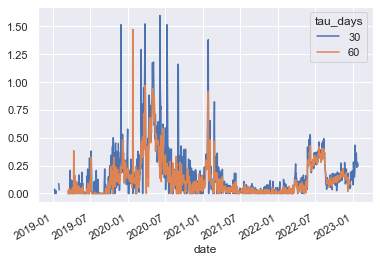

In [55]:
df_impl_div.pivot(index='date', columns='tau_days')['impl_div'][[30, 60]].plot();

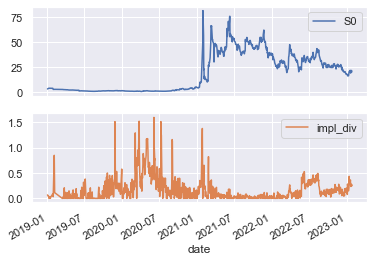

In [56]:
df[['date', 'S0']].drop_duplicates().merge(df_impl_div[df_impl_div['tau_days']==30][['date', 'impl_div']], 
                                           on='date').set_index('date', drop=True).plot(subplots=True);

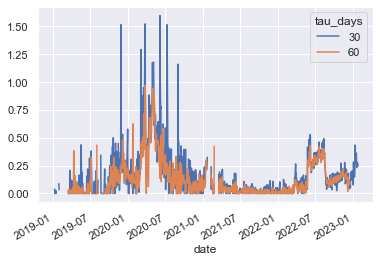

In [15]:
df_impl_div.pivot(index='date', columns='tau_days')['impl_div'][[30, 60]].plot();

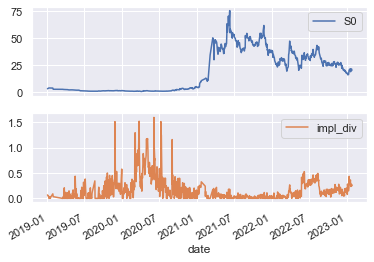

In [16]:
df[['date', 'S0']].drop_duplicates().merge(df_impl_div[df_impl_div['tau_days']==30][['date', 'impl_div']], 
                                           on='date').set_index('date', drop=True).plot(subplots=True);

In [57]:
df_tracer = pd.merge(df_tracer, df_impl_div, how='left', on=['date', 'tau_days'])
df_tracer['adjDelta'] = bs_delta(
    df_tracer['IV0'], df_tracer['K'], df_tracer['K'], df_tracer['tau'], df_tracer['r'], df_tracer['impl_div'], df_tracer['cp_flag'])

# Filter data

In [58]:
def filter_data_post_tracer(df):
    orig_size = len(df)

    #---------------------------------
    # Keep out-of-the-money options only
    #---------------------------------
    bl = (df['cp_flag'].eq('C') & df['M0'].gt(1.001)) | (df['cp_flag'].eq('P') & df['M0'].lt(0.999))
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due being in-the-money.')
    df = df.loc[~bl]


    #---------------------------------
    # Remove far out-of-the-money options
    #---------------------------------
    bl = ((df['cp_flag'] == 'C') & (df['M0'] < 0.8)) | ((df['cp_flag'] == 'P') & (df['M0'] > 1.25))
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed because they are too far out of-the-money.')
    df = df.loc[~bl]
    

    #--------------------
    # Filter by Maturity, part I
    #--------------------
    bl = df['tau_days'].le(7)
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due being too close to expiry.')
    df = df[~bl]


    #--------------------
    # Filter by Maturity, part II
    #--------------------
    bl = df['tau'].gt(1)
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due to time to expiry larger than 1 year.')
    df = df[~bl]
    
    
    #----------------------------------------------------
    #  filter all the options with negative time value
    #----------------------------------------------------
    bl_c = (df['cp_flag'] == 'C') & (df['S0'] - np.exp(-df['r'] * df['tau']) * df['K'] >= df['V0'])
    bl_p = (df['cp_flag'] == 'P') & (np.exp(-df['r'] * df['tau']) * df['K'] - df['S0'] >= df['V0'])
    bl = bl_c | bl_p
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due negative time value.')   
    df = df.loc[~bl]
 
    
    n_removed = orig_size - len(df)
    print(f'Removed in total: {n_removed} ({n_removed/orig_size*100:.2f}%) of all options. New data size: {len(df)}.') 
    return df

In [59]:
df = filter_data_post_tracer(df)

There are 159291 (29.93%) option days that are removed due being in-the-money.
There are 267744 (71.79%) option days that are removed because they are too far out of-the-money.
There are 19247 (18.30%) option days that are removed due being too close to expiry.
There are 2461 (2.86%) option days that are removed due to time to expiry larger than 1 year.
There are 0 (0.00%) option days that are removed due negative time value.
Removed in total: 448743 (84.31%) of all options. New data size: 83495.


# Fill in implied vols and compute deltas

In [20]:
%%time
## fill in implied vols
# df['IV0_is_inputed'] = df['IV0'].isna()
# df.loc[df['IV0'].isna(), 'IV0'] = df.loc[df['IV0'].isna(), :].apply(lambda x:bs_IV(**x), axis=1)

CPU times: user 4.36 s, sys: 21.5 ms, total: 4.38 s
Wall time: 4.37 s


In [61]:
## merge implied dividends with options df
df_impl_div_wide = df_impl_div.pivot(index='date', columns='tau_days')['impl_div'].ffill(axis=1).bfill(axis=1)
df_impl_div_wide[1] = df_impl_div_wide[min(df_impl_div_wide.columns)]
max_tau_days = df['tau_days'].max()
df_impl_div_wide[max_tau_days] = df_impl_div_wide[max(df_impl_div_wide.columns)]
tmp_df = pd.DataFrame(
    np.nan, columns=list(set(np.arange(2, max_tau_days)).difference(df_impl_div_wide.columns)), index=df_impl_div_wide.index)
df_impl_div_wide = pd.concat([df_impl_div_wide, tmp_df], axis=1)
df_impl_div_wide = df_impl_div_wide.reindex(sorted(df_impl_div_wide.columns), axis=1)
df_impl_div_wide = df_impl_div_wide.interpolate(axis=1).reset_index()
df_impl_div_narrow = pd.melt(df_impl_div_wide, id_vars='date', var_name='tau_days', value_name='impl_div')
df = pd.merge(df, df_impl_div_narrow, on=['date', 'tau_days'], how='left')

In [62]:
df['normDelta'] = bs_delta(df['IV0'], df['S0'], df['K'], df['tau'], df['r'], 0, df['cp_flag'])
df['delta_is_inputed'] = df['delta'].isna()
df.loc[df['delta'].isna(), 'delta'] = df.loc[df['delta'].isna(), 'normDelta'] 
df['adjDelta'] = bs_delta(df['IV0'], df['S0'], df['K'], df['tau'], df['r'], df['impl_div'], df['cp_flag'])

#### Delta-Delta plots on raw data

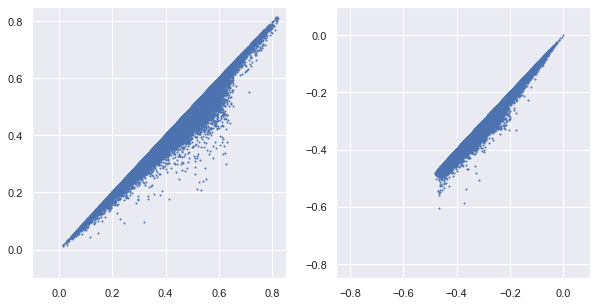

In [63]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))         
axs[0].scatter(df.loc[df['cp_flag'] == 'C', 'normDelta'], df.loc[df['cp_flag'] == 'C', 'adjDelta'], s=1)
axs[0].set_ylim([-0.1, 0.85])
axs[0].set_xlim([-0.1, 0.85])
axs[1].scatter(df.loc[df['cp_flag'] == 'P', 'normDelta'], df.loc[df['cp_flag'] == 'P', 'adjDelta'], s=1)
axs[1].set_ylim([- 0.85, 0.1])
axs[1].set_xlim([- 0.85, 0.1]);

#### Delta-Delta plots on tracer data

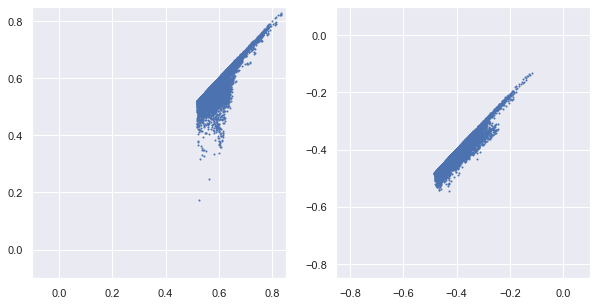

In [64]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))         
axs[0].scatter(df_tracer.loc[df_tracer['cp_flag'] == 'C', 'normDelta'], df_tracer.loc[df_tracer['cp_flag'] == 'C', 'adjDelta'], s=1)
axs[0].set_ylim([-0.1, 0.85])
axs[0].set_xlim([-0.1, 0.85])
axs[1].scatter(df_tracer.loc[df_tracer['cp_flag'] == 'P', 'normDelta'], df_tracer.loc[df_tracer['cp_flag'] == 'P', 'adjDelta'], s=1)
axs[1].set_ylim([- 0.85, 0.1])
axs[1].set_xlim([- 0.85, 0.1]);

# Regression

In [65]:
%%time

# instead of df, can also be used with df_tracer[df_tracer['V1'].notnull()]
dict_coef, dict_plot = regression_rolling(df, delta_type='normDelta', train_length=126, exp_weight=0.99)

CPU times: user 12.4 s, sys: 1.37 s, total: 13.7 s
Wall time: 17.2 s


In [66]:
def plot_scatter(dict_plot, date_in):
    dict = dict_plot[date_in]

    fig, axs = plt.subplots(1, 2, figsize=(18,9), sharey=True)
    axs[0].set_ylabel("Change of option price")

    for cp_flag, name, ax in zip(['C', 'P'], ['Call', 'Put'], axs):
        dict_tmp = dict[cp_flag]
        w = dict_tmp['w_train'] * 30
        ax.scatter(dict_tmp['x_train'], dict_tmp['y_train'], s=w)
        ax.plot(dict_tmp['x_train'], dict_tmp['coef'] * dict_tmp['x_train'], color='tab:orange')
        ax.scatter(dict_tmp['x_test'], dict_tmp['y_test'], color='tab:red')
        ax.annotate(f'{name} coefficient: ' + str(round(dict_tmp['coef'], 2)), 
                        xy=(0, 1), xytext=(12, -12), va='top', xycoords='axes fraction', textcoords='offset points')
        ax.set_title(f'{name}: {date_in}')
        ax.set_xlabel(f"{dict_tmp['delta_type']} X Change of stock price")
    
    fig.tight_layout()   
    plt.close()
    return fig

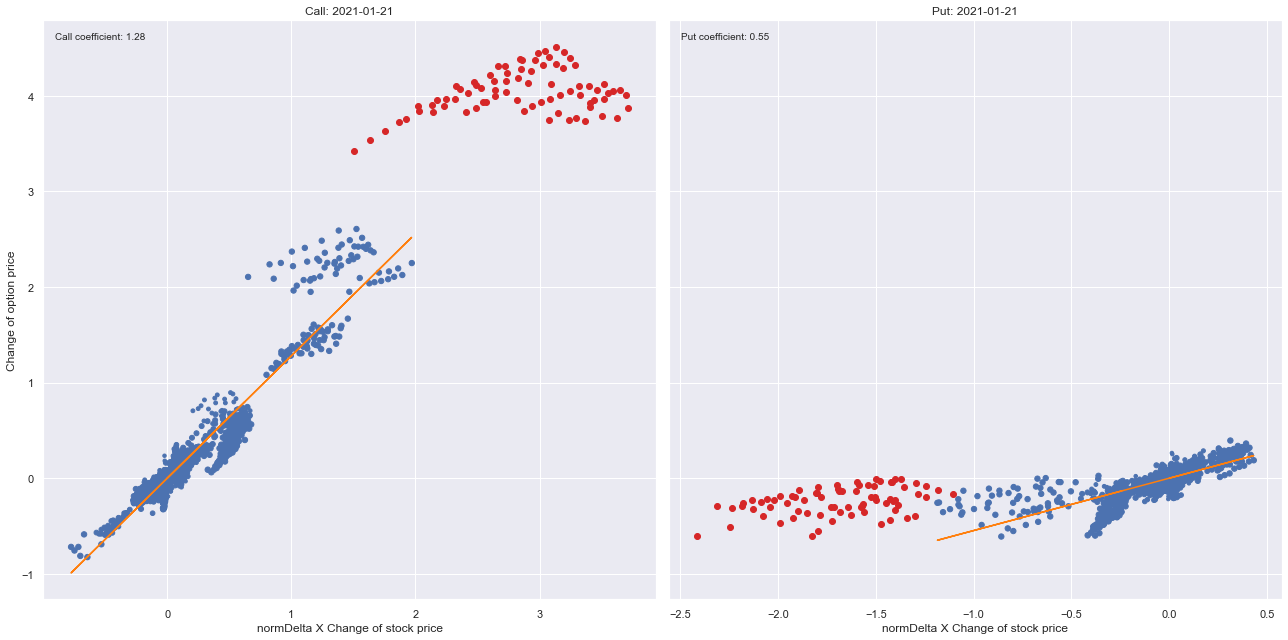

In [67]:
plot_scatter(dict_plot, '2021-01-21')

In [68]:
df_coef_ts = pd.DataFrame()
for key in dict_coef:
    df_coef_ts.loc[key, 'date'] = pd.to_datetime(key)
    df_coef_ts.loc[key, 'coef_C'] = dict_coef[key]['C']['coef']
    df_coef_ts.loc[key, 'N_train_C'] = dict_coef[key]['C']['N_train']
    df_coef_ts.loc[key, 'days_train_C'] = dict_coef[key]['C']['days_train']
    df_coef_ts.loc[key, 'N_test_C'] = dict_coef[key]['C']['N_test']

    df_coef_ts.loc[key, 'coef_P'] = dict_coef[key]['P']['coef']
    df_coef_ts.loc[key, 'N_train_P'] = -dict_coef[key]['P']['N_train']
    df_coef_ts.loc[key, 'days_train_P'] = dict_coef[key]['P']['days_train']
    df_coef_ts.loc[key, 'N_test_P'] = dict_coef[key]['P']['N_test']
    
df_coef_ts = df_coef_ts.sort_values(['date'])
df_coef_ts['coef_C_SMA10'] = df_coef_ts['coef_C'].rolling(10).mean()
df_coef_ts['coef_P_SMA10'] = df_coef_ts['coef_P'].rolling(10).mean()
df_coef_ts['N_train_C_SMA10'] = df_coef_ts['N_train_C'].rolling(10).mean()
df_coef_ts['N_train_P_SMA10'] = df_coef_ts['N_train_P'].rolling(10).mean()

tau_days = 60
df_syn_C = df_tracer.loc[(df_tracer['tau_days'] == tau_days) & (df_tracer['cp_flag'] == 'C'), ['date', 'V0', 'IV0', 'impl_div']].rename(columns = {'V0':'V0_C', 'IV0':'IV0_C'})
df_syn_P = df_tracer.loc[(df_tracer['tau_days'] == tau_days) & (df_tracer['cp_flag'] == 'P'), ['date', 'V0', 'IV0']].rename(columns = {'V0':'V0_P', 'IV0':'IV0_P'})
df_syn = pd.merge(df[['date', 'S0']].drop_duplicates(), df_syn_C, how='left', on=['date'])
df_syn = pd.merge(df_syn, df_syn_P, how='left', on=['date'])

df_coef_ts = df_syn.merge(df_coef_ts, how='left', on='date').sort_values(['date'])

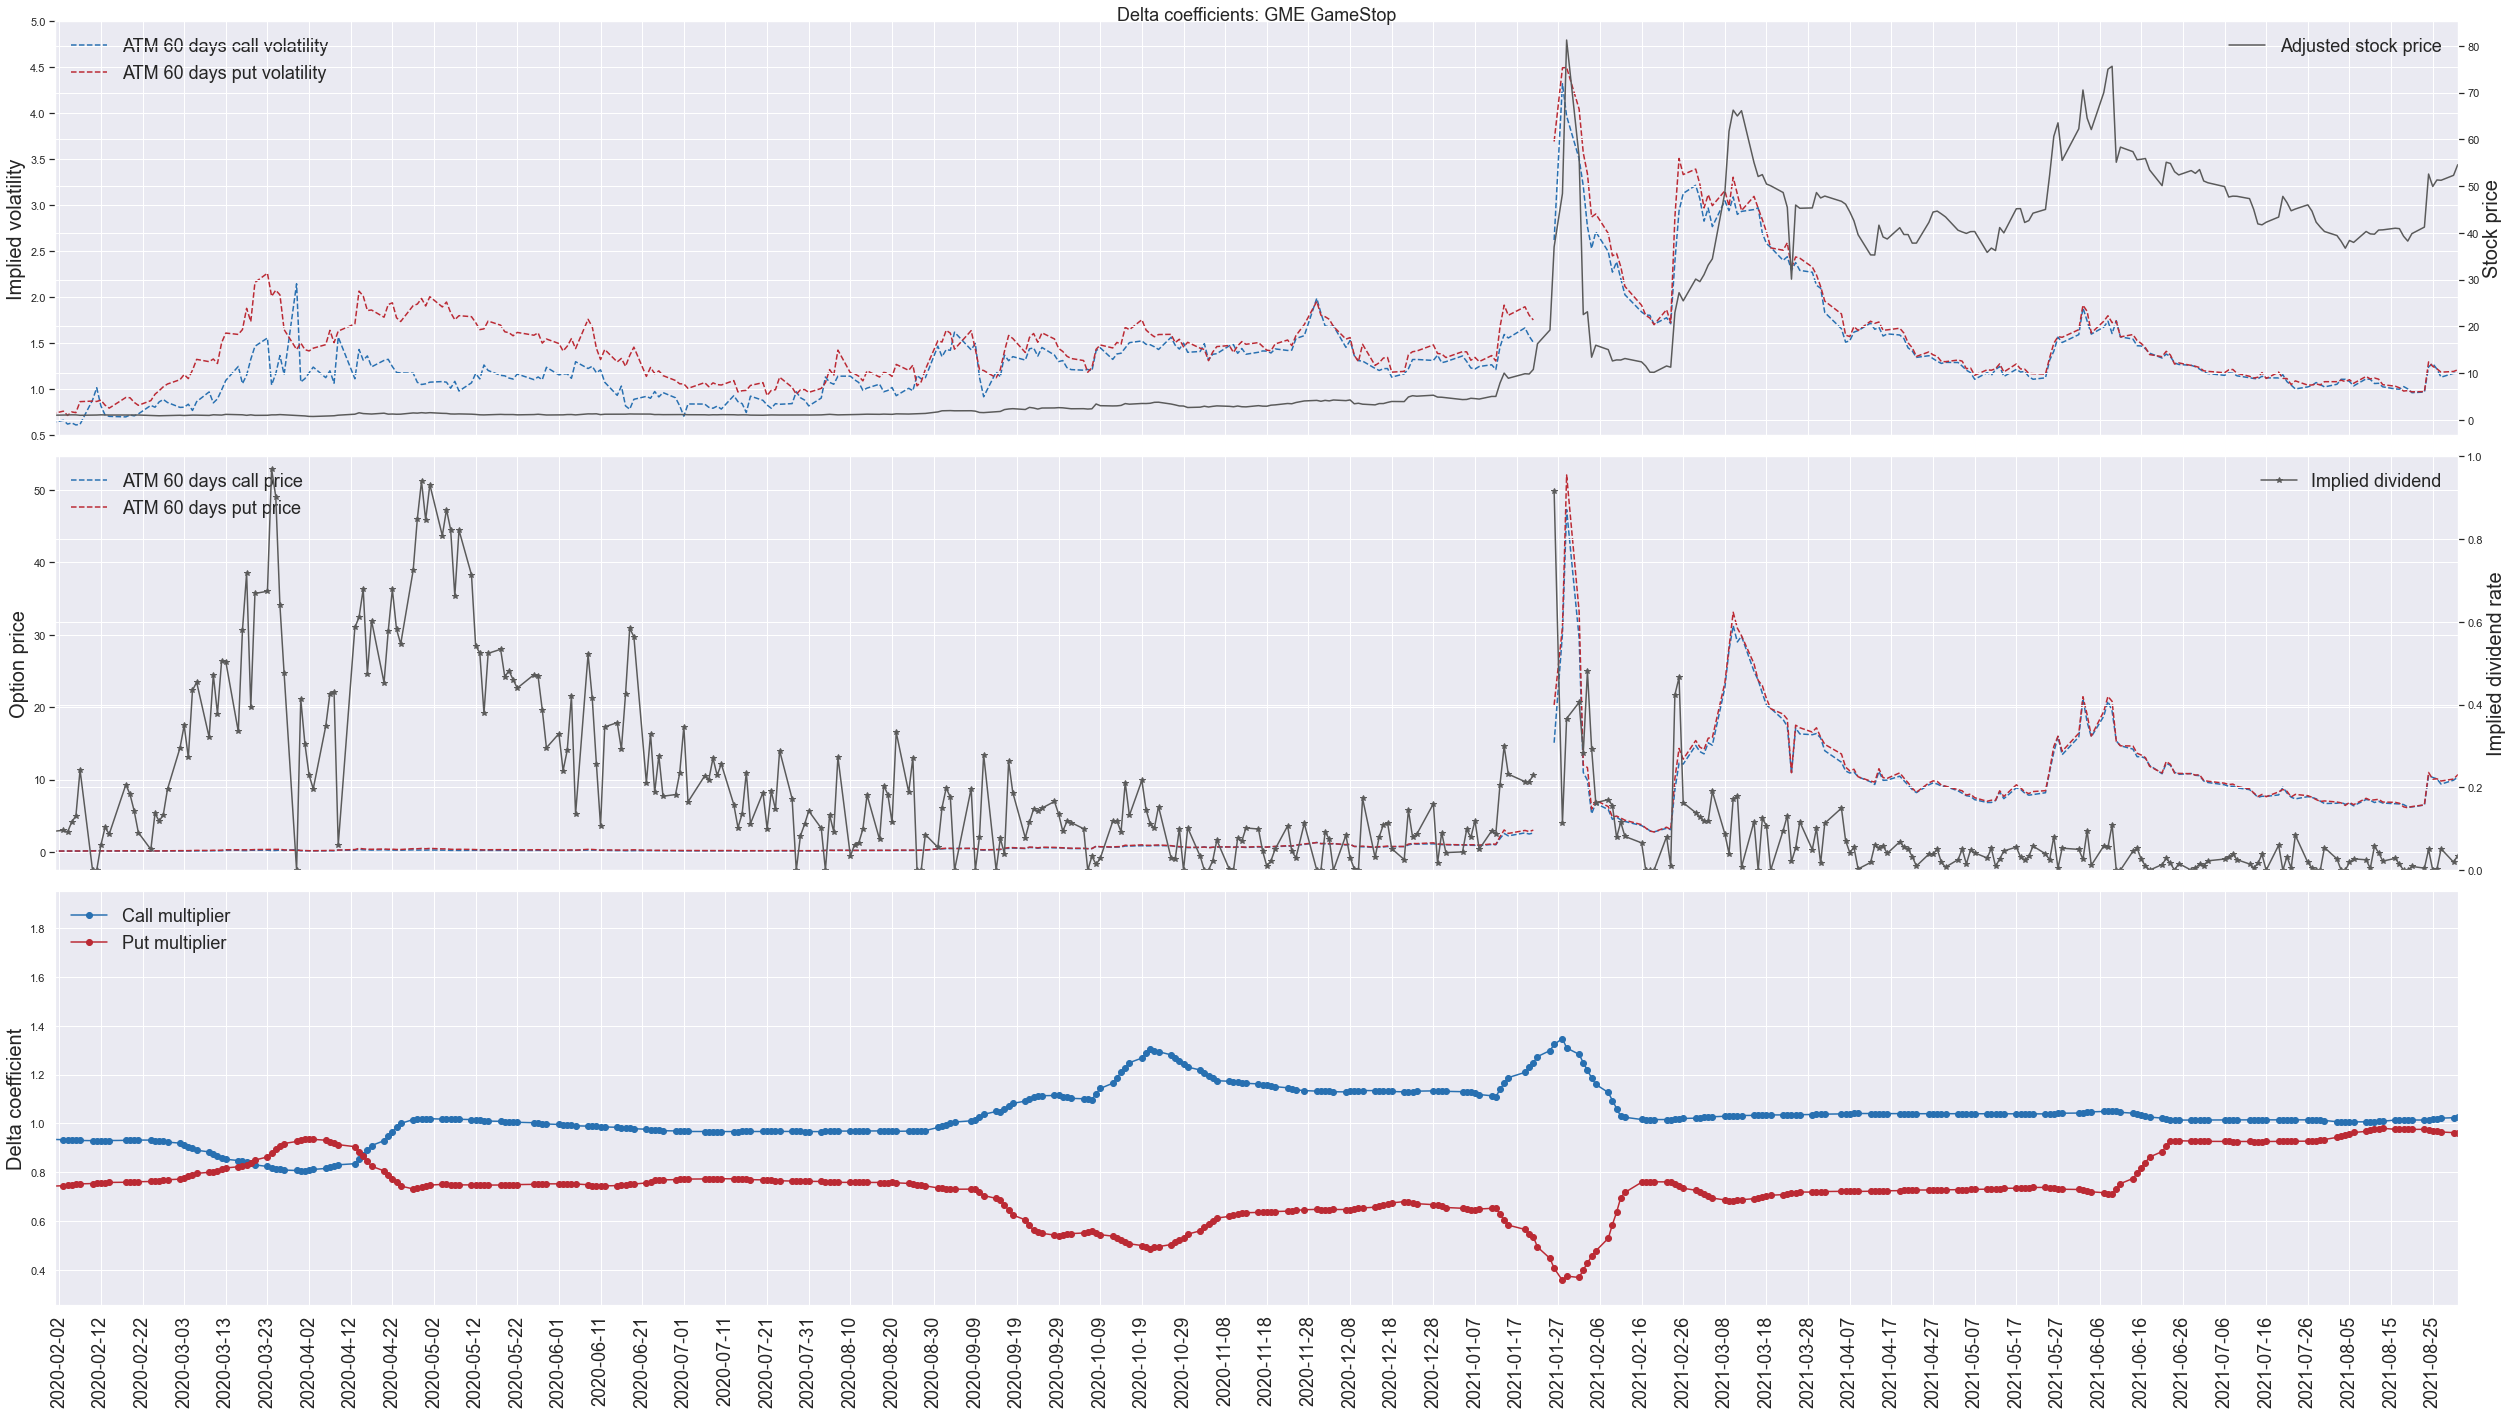

In [70]:
import matplotlib.dates as mdates


fig, axs = plt.subplots(3, 1, figsize=(35, 20), sharex=True)       

axs[0].plot(df_coef_ts['date'], df_coef_ts['IV0_C'], color=sns.color_palette("RdBu", n_colors=7)[6], linestyle='dashed', label=f'ATM {tau_days} days call volatility')
axs[0].plot(df_coef_ts['date'], df_coef_ts['IV0_P'], color=sns.color_palette("RdBu", n_colors=7)[0], linestyle='dashed', label=f'ATM {tau_days} days put volatility')
axs[0].set_ylabel("Implied volatility", fontsize=20) 
axs[0].set_ylim([0.5, 5]) 
axs[0].legend(loc=2, frameon=False, fontsize=18)  
ax0 = axs[0].twinx()
ax0.plot(df_coef_ts['date'], df_coef_ts['S0'], color=sns.color_palette("RdGy", n_colors=7)[6], label='Adjusted stock price')
ax0.set_ylabel("Stock price", fontsize=20)
ax0.legend(loc=1, frameon=False, fontsize=18)

axs[1].plot(df_coef_ts['date'], df_coef_ts['V0_C'], color=sns.color_palette("RdBu", n_colors=7)[6], linestyle='dashed', label=f'ATM {tau_days} days call price')
axs[1].plot(df_coef_ts['date'], df_coef_ts['V0_P'], color=sns.color_palette("RdBu", n_colors=7)[0], linestyle='dashed', label=f'ATM {tau_days} days put price')
axs[1].set_ylabel("Option price", fontsize=20)
axs[1].legend(loc=2, frameon=False, fontsize=18)
ax1 = axs[1].twinx()
ax1.plot(df_coef_ts['date'], df_coef_ts['impl_div'], color=sns.color_palette("RdGy", n_colors=7)[6], marker='*', label='Implied dividend')
ax1.set_ylabel("Implied dividend rate", fontsize=20)
ax1.set_ylim([0, 1]) 
ax1.legend(loc=1, frameon=False, fontsize=18)  

axs[2].plot(df_coef_ts['date'], df_coef_ts['coef_C_SMA10'], color=sns.color_palette("RdBu", n_colors=7)[6], marker='o', label='Call multiplier')
axs[2].plot(df_coef_ts['date'], df_coef_ts['coef_P_SMA10'], color=sns.color_palette("RdBu", n_colors=7)[0], marker='o', label='Put multiplier') 
axs[2].set_ylabel("Delta coefficient", fontsize=20)
axs[2].legend(loc=2, frameon=False, fontsize=18)
# ax2 = axs[2].twinx()
# ax2.plot(df_coef_ts['date'], df_coef_ts['N_train_C_SMA10'], color=sns.color_palette("RdBu", n_colors=7)[6], alpha=0.5, label="Call: number of training observations")
# ax2.plot(df_coef_ts['date'], df_coef_ts['N_train_P_SMA10'], color=sns.color_palette("RdBu", n_colors=7)[0], alpha=0.5, label="Put: number of training observations")
# ax2.set_ylabel("Number of observations in training", fontsize=20)  
# ax2.legend(loc=1, frameon=False) 
# max_tmp = max(df_coef_ts['N_train_C_SMA10'].max(), df_coef_ts['N_train_P_SMA10'].max())
# ax2.set_ylim(-max_tmp, max_tmp)

axs[2].xaxis.set_major_locator(mdates.DayLocator(interval=10))
axs[2].set_xlim([pd.to_datetime('2020-02-01'), pd.to_datetime('2021-08-31')])
plt.setp(axs[2].get_xticklabels(), rotation=90, fontsize=18)
fig.suptitle('Delta coefficients: ' + ticker + ' ' + name, fontsize=18)
fig.tight_layout()

In [81]:
df_tracer.loc[('2021-01-19' < df_tracer['date']) & (df_tracer['date'] < '2021-02-03') & (df_tracer['tau_days'] == 120), :]

,date,S0,S1,IV0,K,cp_flag,tau_days,tau,short_rate,r,V0,V1,normDelta,impl_div,adjDelta
13972,2021-01-20,9.7800,10.7575,1.421859,9.7800,C,120,0.333333,0.001020,0.001783,3.117185,3.676954,0.659529,0.158098,0.635698
13973,2021-01-21,10.7575,16.2525,1.409436,10.7575,C,120,0.333333,0.000983,0.001728,3.400369,7.520193,0.658208,0.170794,0.632173
13974,2021-01-26,36.9950,86.8775,1.994618,36.9950,C,120,0.333333,0.000929,0.001703,16.107905,61.338924,0.717790,0.591499,0.657290
13975,2021-01-28,48.4000,81.2500,3.340661,48.4000,C,120,0.333333,0.000930,0.001661,32.197136,58.271863,0.832641,0.105464,0.828034
13976,2021-01-29,81.2500,56.2500,3.073656,81.2500,C,120,0.333333,0.000947,0.001568,50.795399,28.496447,0.812617,0.309827,0.796557
13977,2021-02-01,56.2500,22.5000,2.784704,56.2500,C,120,0.333333,0.000843,0.001555,32.548496,7.180754,0.789358,0.338971,0.768501
13978,2021-02-02,22.5000,23.1025,2.471545,22.5000,C,120,0.333333,0.000862,0.001561,11.802846,11.024303,0.762336,0.270393,0.742372
14875,2021-01-20,9.7800,10.7575,1.668157,9.7800,P,120,0.333333,0.001020,0.001783,3.613429,3.317441,-0.314842,0.158098,-0.334524
14876,2021-01-21,10.7575,16.2525,1.674861,10.7575,P,120,0.333333,0.000983,0.001728,3.989506,3.512800,-0.314162,0.170794,-0.335341
14877,2021-01-26,36.9950,86.8775,3.004552,36.9950,P,120,0.333333,0.000929,0.001703,22.707015,22.757926,-0.192788,0.591499,-0.225423
